<a href="https://colab.research.google.com/github/trngbro/AI/blob/main/Progress20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload input if not exist

Chạy đoạn mã dưới đây, ngay sau khi xuất hiện **Choose Files** thì lập tức bấm vào và chọn file txt input để chạy thuật toán. Sau quá trình tải lên (đạt 100% trạng thái) thì sẽ xuất ra màn hình thông tin file tải lên. Kiểm tra và chắc chắn là tải lên đúng file.

Có thể lấy file mẫu tại đây: *`matrix.txt`*

Cũng có thể kiểm tra rằng file đã tải lên hay chưa bằng cách kiểm tra có file matrix.txt tồn tại ở folder colab hay chưa (hình minh hoạ đính kèm).
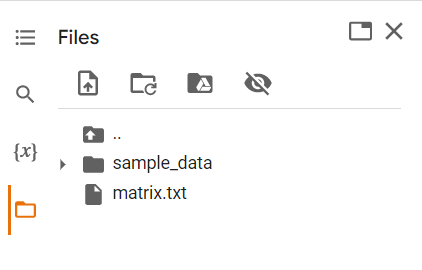

In [41]:
import os.path
from google.colab import files

if not (os.path.isfile("matrix.txt")):
  uploaded = files.upload()
  file_name = "matrix.txt"
with open('matrix.txt', 'r') as f:
  data = f.readlines()
  print("Các dòng đầu của file:")
  for line in data[:8]:
      print(line)

Các dòng đầu của file:
4 4

2 . 1 .

. . . .

1 . 1 .


# Read file

- Đầu vào là file đã nạp ở trên

- Dòng đầu là kích thước ma trận

- Lần lược đọc giá trị các dòng, trong đó:

-- Nếu là số thì duyệt vào mảng

-- Nếu khác thì bỏ qua, cập nhật giá trị rỗng

In [60]:
def read_file():
    try:
        with open('matrix.txt', 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print("File 'matrix.txt' not found!")
        return None
    except IOError:
        print("Cannot read file 'matrix.txt'!")
        return None

    # Loại bỏ khoảng trắng và ký tự xuống dòng
    lines = [line.strip() for line in lines]
    # Lấy kích thước ma trận
    m, n = map(int, lines[0].split())
    # Tạo ma trận với kích thước m x n
    matrix = [[None] * n for _ in range(m)]
    # Đọc các giá trị trong ma trận
    for i in range(1, m+1):
        row = lines[i].split()
        for j in range(n):
            if row[j].isdigit():
                matrix[i-1][j] = int(row[j])
            else:
                matrix[i-1][j] = ''
    # Trả về ma trận dưới dạng mảng 2 chiều
    return matrix

read_file()

[[2, '', 1, ''], ['', '', '', ''], [1, '', 1, ''], [2, 3, 4, 6]]

# Main function

## Cài thư viện

Tìm hiểu và sử dụng thư viện **Glucose3** để giải ma trận với propositional
logic. Cài đặt PySAT theo lệnh bên dưới.
Tài liệu về Glucose3: https://pysathq.github.io/docs/html/api/solvers.html

In [43]:
!pip install python-sat==0.1.7.dev12

from pysat.solvers import Glucose3
import matplotlib.pyplot as plt
import itertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Xử lý bài

***Hàm xuất ma trận dưới dạng bảng với các màu đã tô***

In [44]:
def matrix_coloring(matrix_color):
    color_map = {'red': (204, 0, 0), 'green': (78, 154, 6)}
    colors = [[color_map[val] for val in row] for row in matrix_color]

    fig, ax = plt.subplots()

    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(colors)

    plt.show()

***Mô tả quy trình thực hiện của bài toán:***

- Hàm **`get_propositions(matrix)`**: hàm này lấy ma trận đầu vào và trả về danh sách các điểm chứa số (propositions) của ma trận đó. Mỗi điểm được biểu diễn bằng một cặp tọa độ (i, j) của ô trong ma trận.

- Hàm **`get_neighbors(prop, matrix)`**: truyền vào vị trí của một điểm và nhận về các điểm lân cận của điểm đó.

- Hàm **`generate_clauses(props, matrix)`**: hàm này lấy danh sách các điểm đặc biệt và ma trận đầu vào, và trả về danh sách các mệnh đề (clauses) được tạo ra từ điểm và ma trận. Một mệnh đề được biểu diễn bằng một danh sách các số nguyên, mỗi số nguyên là một biến trong biểu thức logic được sử dụng để giải quyết bài toán.

- Hàm **`solve(matrix)`**: hàm này lấy ma trận đầu vào và sử dụng các hàm trên để giải quyết bài toán tô màu ma trận. Hàm này trả về ma trận tô màu tương ứng hoặc None nếu không tìm được lời giải.

In [45]:
def get_propositions(matrix):
    props = []
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if matrix[i][j] != '' and matrix[i][j]!=0:
                props.append((i, j))
    return props

def get_neighbors(prop, matrix):
    neighbors = []
    i, j = prop
    for x in range(max(0, i-1), min(i+2, len(matrix))):
        for y in range(max(0, j-1), min(j+2, len(matrix[0]))):
            if matrix[x][y] != '' and matrix[x][y]!=0:
                neighbors.append((x, y))
    return neighbors

# Tạo ra CNF :>> nhưng mà lạ lắm
def generate_clauses(props, matrix):
    clauses = []
    for p in props:
        neighbors = get_neighbors(p, matrix)
        num_green = matrix[p[0]][p[1]]
        for comb in combinations(neighbors, num_green):
            clause = []
            for n in neighbors:
                if n in comb:
                    clause.append(get_index(n, props) + 1)
                else:
                    clause.append(-(get_index(n, props) + 1))
            clauses.append(clause)
        if num_green == 0:
            for n in neighbors:
                clauses.append([-1 * (get_index(n, props) + 1)])
    return clauses


def get_index(prop, props):
    return props.index(prop)

def solve(matrix):
    props = get_propositions(matrix)
    clauses = generate_clauses(props, matrix)
    with Glucose3() as solver:
        for clause in clauses:
            solver.add_clause(clause)
        res = solver.solve()
        if res == False:
            return None
        result = [['red' for j in range(len(matrix[0]))] for i in range(len(matrix))]
        for p in props:
            if solver.get_model()[get_index(p, props)] > 0:
                result[p[0]][p[1]] = 'green'
        matrix_coloring(result)
        return result

# Test

Kiểm thử lại các hàm đã thực hiệm

In [76]:
matrix = (read_file())

print('Dữ liệu đọc file:')
print(matrix)

print('\n\nKết quả đã xử lý:')
matrix_color = solve(matrix)

print('List color -> ', matrix_color)

Dữ liệu đọc file:
[[1, '', '', '', '', '', 1], ['', '', '', '', 3, '', '']]


Kết quả đã xử lý:


IndexError: ignored

# Draft

In [62]:
_matrix = [
	['',  2,  3, '', '',  0, '', '', '', ''],
	['', '', '', '',  3, '',  2, '', '',  6],
	['', '',  5, '',  5,  3, '',  5,  7,  4],
	['',  4, '',  5, '',  5, '',  6, '',  3],
	['', '',  4, '',  5, '',  6, '', '',  3],
	['', '', '',  2, '',  5, '', '', '', ''],
	[ 4, '',  1, '', '', '',  1,  1, '', ''],
	[ 4, '',  1, '', '', '',  1, '',  4, ''],
	['', '', '', '',  6, '', '', '', '',  4],
	['',  4,  4, '', '', '', '',  4, '', '']
] 

'''
[
	[R, G, G, R, R, R, R, R, G, G],
	[R, R, R, G, R, R, R, G, G, G],
	[R, R, G, G, G, R, R, G, G, G],
	[R, G, G, R, G, G, R, G, R, R],
	[R, G, R, R, R, G, G, G, G, R],
	[G, G, R, R, G, G, R, R, G, G],
	[G, R, R, R, G, R, R, R, R, G],
	[G, R, R, R, G, R, R, R, R, G],
	[G, G, R, R, G, G, R, R, G, G],
	[R, G, G, G, G, G, G, G, G, R]
] 
'''

'\n[\n\t[R, G, G, R, R, R, R, R, G, G],\n\t[R, R, R, G, R, R, R, G, G, G],\n\t[R, R, G, G, G, R, R, G, G, G],\n\t[R, G, G, R, G, G, R, G, R, R],\n\t[R, G, R, R, R, G, G, G, G, R],\n\t[G, G, R, R, G, G, R, R, G, G],\n\t[G, R, R, R, G, R, R, R, R, G],\n\t[G, R, R, R, G, R, R, R, R, G],\n\t[G, G, R, R, G, G, R, R, G, G],\n\t[R, G, G, G, G, G, G, G, G, R]\n] \n'

In [66]:
def check(arrays):
    num_cols = len(arrays[0])
    for array in arrays:
        if len(array) != num_cols:
            return False
    return True

print(check(_matrix))


True


In [68]:
solve(_matrix)

IndexError: ignored